In [4]:
#!pip install pendulum

In [69]:
%load_ext autoreload
%autoreload 2

import pandas as pd
import numpy as np
import datetime

import os
import pendulum
import scipy
import scikit_posthocs as sp
import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt
import plotly.express as px

# Load Statsmodels 
import statsmodels.api as sm
from pandas.tseries.holiday import USFederalHolidayCalendar as calendar
from statsmodels.stats.multicomp import pairwise_tukeyhsd

import plotly
from plotly.offline import init_notebook_mode
init_notebook_mode(connected=True)
plotly.offline.init_notebook_mode(connected=True)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [70]:
# Configure Pandas to display all columns and rows
pd.set_option("display.max.columns", None)
pd.set_option("display.max.rows", None)

# Suitable default display for floats
pd.options.display.float_format = '{:,.2f}'.format

%matplotlib inline
plt.rcParams["figure.figsize"] = (10,8)
sns.set_style("whitegrid")
sns.set_style("ticks", {"xtick.major.size": 8, "ytick.major.size": 8})

from IPython.core.display import display, HTML
display(HTML("<style>.container { width:85% !important; }</style>"))

## What is the problem at hand?

**As one of the world’s leading brewers, Anheuser-Busch has a variety of different brands and works with a lot of wholesalers and retailers. One of the leading challenges in serving consumers is to ensure product-availability with wholesalers. Based on market research, when consumers notice their favourite brand is missing from the shelves of retailers, they may quickly make the choice for a competitor’s brand instead.**


**Hence, it is important to understand the demand of the products in advance. That could help the brewers plan better to have good inventory, would in-turn help the wholesalers have enough stock for the retailers to have customers' favourite products on-shelf!  For example, if the breweries get a high demand forecast for the next few days or weeks, they can ramp up the manufacturing supply accordingly and ensure customer satisfaction and effective sales.**

## Potential solution?

**`Using 5 years worth of weekly sales/demand data, we could try to learn from the trends and signals and build a model to effectively forecase demand for 2 weeks ahead. We could utilize this model to better plan for future and in-return not only help the wholesalers and retailers ensure availibility of popular products but also ensure customer satisfaction.`**

**`To build an MVP, we would build a forecasting model for 5 products for 2 wholesalers from 2 different states - NY & TX for the next 2 weeks.`**

## Load NY & TX data

In [71]:
ny_df = pd.read_csv('data/ny_df.csv')
tx_df = pd.read_csv('data/tx_df.csv')

In [72]:
ny_df.head()

,PRODUCT_KEY,GEOGRAPHY_KEY,TIME_KEY,UNIT_SALES,DOLLAR_SALES,VOLUME_SALES,WEEKLY_DATE,GEOGRAPHY_KEY.1,GEOGRAPHY_DESCRIPTION,WHOLESALER_ID_VALUE,RETAILER_NAME,CITY,STATE_CODE,ZIP_CODE,OUTLET_NAME,PRODUCT_KEY.1,PRODUCT_DESCRIPTION,AB_CATEGORY_STYLE_VALUE,AB_WAMP_VALUE,BEER_STYLE_VALUE,BRAND_VALUE,BREWER_VALUE,TYPE_VALUE
0,1412422,258891,2051,22.00,318.78,11.00,2018-12-23,258891,"WEGMANS 91 : 601 AMHERST ST, BUFFALO, NY",33107,WEGMANS - WEGMANS,BUFFALO,NY,14207,GROCERY,1412422,**********,EASY DRINKING,PREMIUM,TROPICAL LAGER,**********,CONSTELLATION BRANDS,BEER
1,609521221,258891,2051,32.00,479.68,16.00,2018-12-23,258891,"WEGMANS 91 : 601 AMHERST ST, BUFFALO, NY",33107,WEGMANS - WEGMANS,BUFFALO,NY,14207,GROCERY,609521221,**********,HARD BEVERAGES (BEER),BEYOND BEER,VARIETY PACK/SAMPLER,**********,BOSTON BEER CO,MALT BEVERAGE
2,1321133691,258891,2051,33.00,494.67,16.50,2018-12-23,258891,"WEGMANS 91 : 601 AMHERST ST, BUFFALO, NY",33107,WEGMANS - WEGMANS,BUFFALO,NY,14207,GROCERY,1321133691,**********,HARD BEVERAGES (BEER),BEYOND BEER,VARIETY PACK/SAMPLER,**********,BOSTON BEER CO,MALT BEVERAGE
3,659550424,258891,2051,30.00,448.70,15.00,2018-12-23,258891,"WEGMANS 91 : 601 AMHERST ST, BUFFALO, NY",33107,WEGMANS - WEGMANS,BUFFALO,NY,14207,GROCERY,659550424,**********,HARD BEVERAGES (BEER),BEYOND BEER,VARIETY PACK/SAMPLER,**********,MARK ANTHONY BRANDS INC,MALT BEVERAGE
4,262793636,258891,2051,22.00,373.78,13.80,2018-12-23,258891,"WEGMANS 91 : 601 AMHERST ST, BUFFALO, NY",33107,WEGMANS - WEGMANS,BUFFALO,NY,14207,GROCERY,262793636,**********,CRAFT & STYLES,PREMIUM,IPA,**********,FOUNDERS BREWING CO,BEER


## Merge the two dataframes

In [73]:
state_dfs = [ny_df, tx_df]

df = pd.concat(state_dfs)

df.shape

(2534, 23)

In [74]:
# Convert column names to lowercase

df.columns = df.columns.str.lower()

In [75]:
df.head()

,product_key,geography_key,time_key,unit_sales,dollar_sales,volume_sales,weekly_date,geography_key.1,geography_description,wholesaler_id_value,retailer_name,city,state_code,zip_code,outlet_name,product_key.1,product_description,ab_category_style_value,ab_wamp_value,beer_style_value,brand_value,brewer_value,type_value
0,1412422,258891,2051,22.00,318.78,11.00,2018-12-23,258891,"WEGMANS 91 : 601 AMHERST ST, BUFFALO, NY",33107,WEGMANS - WEGMANS,BUFFALO,NY,14207,GROCERY,1412422,**********,EASY DRINKING,PREMIUM,TROPICAL LAGER,**********,CONSTELLATION BRANDS,BEER
1,609521221,258891,2051,32.00,479.68,16.00,2018-12-23,258891,"WEGMANS 91 : 601 AMHERST ST, BUFFALO, NY",33107,WEGMANS - WEGMANS,BUFFALO,NY,14207,GROCERY,609521221,**********,HARD BEVERAGES (BEER),BEYOND BEER,VARIETY PACK/SAMPLER,**********,BOSTON BEER CO,MALT BEVERAGE
2,1321133691,258891,2051,33.00,494.67,16.50,2018-12-23,258891,"WEGMANS 91 : 601 AMHERST ST, BUFFALO, NY",33107,WEGMANS - WEGMANS,BUFFALO,NY,14207,GROCERY,1321133691,**********,HARD BEVERAGES (BEER),BEYOND BEER,VARIETY PACK/SAMPLER,**********,BOSTON BEER CO,MALT BEVERAGE
3,659550424,258891,2051,30.00,448.70,15.00,2018-12-23,258891,"WEGMANS 91 : 601 AMHERST ST, BUFFALO, NY",33107,WEGMANS - WEGMANS,BUFFALO,NY,14207,GROCERY,659550424,**********,HARD BEVERAGES (BEER),BEYOND BEER,VARIETY PACK/SAMPLER,**********,MARK ANTHONY BRANDS INC,MALT BEVERAGE
4,262793636,258891,2051,22.00,373.78,13.80,2018-12-23,258891,"WEGMANS 91 : 601 AMHERST ST, BUFFALO, NY",33107,WEGMANS - WEGMANS,BUFFALO,NY,14207,GROCERY,262793636,**********,CRAFT & STYLES,PREMIUM,IPA,**********,FOUNDERS BREWING CO,BEER


## Explore data

In [76]:
df.shape

(2534, 23)

In [77]:
# Data types of the columns

df.dtypes

product_key                  int64
geography_key                int64
time_key                     int64
unit_sales                 float64
dollar_sales               float64
volume_sales               float64
weekly_date                 object
geography_key.1              int64
geography_description       object
wholesaler_id_value          int64
retailer_name               object
city                        object
state_code                  object
zip_code                     int64
outlet_name                 object
product_key.1                int64
product_description         object
ab_category_style_value     object
ab_wamp_value               object
beer_style_value            object
brand_value                 object
brewer_value                object
type_value                  object
dtype: object

In [78]:
# conver the date col to datetime
df['dates'] = pd.to_datetime(df['weekly_date'])

df.dtypes

product_key                         int64
geography_key                       int64
time_key                            int64
unit_sales                        float64
dollar_sales                      float64
volume_sales                      float64
weekly_date                        object
geography_key.1                     int64
geography_description              object
wholesaler_id_value                 int64
retailer_name                      object
city                               object
state_code                         object
zip_code                            int64
outlet_name                        object
product_key.1                       int64
product_description                object
ab_category_style_value            object
ab_wamp_value                      object
beer_style_value                   object
brand_value                        object
brewer_value                       object
type_value                         object
dates                      datetim

**There are 23 columns in the data -**
- **few columns that describe the product type**
- **few columns that describe the wholesalers**
- **few columns that describe the weekly sales**

`We will remove a few redundant or masked columns.`

In [79]:
df.city.unique()

array(['BUFFALO', 'LEANDER'], dtype=object)

In [80]:
df.drop(['geography_key.1', 'time_key', 'geography_description', 'geography_key',
         'product_key.1', 'product_description', 'brand_value', 'zip_code', 'city',
         'weekly_date'
        ], axis=1, inplace=True)

df.shape

(2534, 14)

### Is there any missing data?

In [81]:
df.isnull().sum()

product_key                0
unit_sales                 0
dollar_sales               0
volume_sales               0
wholesaler_id_value        0
retailer_name              0
state_code                 0
outlet_name                0
ab_category_style_value    0
ab_wamp_value              0
beer_style_value           0
brewer_value               0
type_value                 0
dates                      0
dtype: int64

**There is no missing data - that is great!**

In [82]:
df = df[['dates', 'wholesaler_id_value', 'state_code', 'retailer_name', 
         'outlet_name', 'product_key', 'ab_category_style_value', 'ab_wamp_value',
         'beer_style_value', 'brewer_value', 'type_value',
         'unit_sales', 'dollar_sales', 'volume_sales' ]]

df.head()

,dates,wholesaler_id_value,state_code,retailer_name,outlet_name,product_key,ab_category_style_value,ab_wamp_value,beer_style_value,brewer_value,type_value,unit_sales,dollar_sales,volume_sales
0,2018-12-23,33107,NY,WEGMANS - WEGMANS,GROCERY,1412422,EASY DRINKING,PREMIUM,TROPICAL LAGER,CONSTELLATION BRANDS,BEER,22.00,318.78,11.00
1,2018-12-23,33107,NY,WEGMANS - WEGMANS,GROCERY,609521221,HARD BEVERAGES (BEER),BEYOND BEER,VARIETY PACK/SAMPLER,BOSTON BEER CO,MALT BEVERAGE,32.00,479.68,16.00
2,2018-12-23,33107,NY,WEGMANS - WEGMANS,GROCERY,1321133691,HARD BEVERAGES (BEER),BEYOND BEER,VARIETY PACK/SAMPLER,BOSTON BEER CO,MALT BEVERAGE,33.00,494.67,16.50
3,2018-12-23,33107,NY,WEGMANS - WEGMANS,GROCERY,659550424,HARD BEVERAGES (BEER),BEYOND BEER,VARIETY PACK/SAMPLER,MARK ANTHONY BRANDS INC,MALT BEVERAGE,30.00,448.70,15.00
4,2018-12-23,33107,NY,WEGMANS - WEGMANS,GROCERY,262793636,CRAFT & STYLES,PREMIUM,IPA,FOUNDERS BREWING CO,BEER,22.00,373.78,13.80


In [83]:
for w in [33107, 34206]:
    for p in [1412422,  609521221, 1321133691,  659550424,  262793636]:
        df_small = df[(df['wholesaler_id_value']== w) & (df['product_key']== p)]
        print(f'For wholesaler {w} & product {p} time series, there are {df_small.shape[0]} weeks in the data')
        print(min(df_small.dates), max(df_small.dates))

For wholesaler 33107 & product 1412422 time series, there are 262 weeks in the data
2018-01-07 00:00:00 2023-01-15 00:00:00
For wholesaler 33107 & product 609521221 time series, there are 246 weeks in the data
2018-01-07 00:00:00 2023-01-15 00:00:00
For wholesaler 33107 & product 1321133691 time series, there are 258 weeks in the data
2018-02-04 00:00:00 2023-01-15 00:00:00
For wholesaler 33107 & product 659550424 time series, there are 263 weeks in the data
2018-01-07 00:00:00 2023-01-15 00:00:00
For wholesaler 33107 & product 262793636 time series, there are 263 weeks in the data
2018-01-07 00:00:00 2023-01-15 00:00:00
For wholesaler 34206 & product 1412422 time series, there are 258 weeks in the data
2018-01-07 00:00:00 2023-01-15 00:00:00
For wholesaler 34206 & product 609521221 time series, there are 245 weeks in the data
2018-01-07 00:00:00 2023-01-15 00:00:00
For wholesaler 34206 & product 1321133691 time series, there are 228 weeks in the data
2018-07-22 00:00:00 2023-01-15 00:

In [84]:
revised_df_list = []

for w in [33107, 34206]:
    for p in [1412422,  609521221, 1321133691,  659550424,  262793636]:
        
        df_small = df[(df['wholesaler_id_value']== w) & (df['product_key']== p)]
        
        new_df = pd.DataFrame()
        new_df['revised_dates'] = pd.date_range(start='2018-01-07', end='2023-01-15', freq='W')
        
        new_df['wholesaler_id_value'] = w
        new_df['product_key'] = p
    
        df_small = df_small[['dates', 'wholesaler_id_value', 'product_key',
                             'unit_sales', 'dollar_sales', 'volume_sales']]
        
        new_df = new_df.merge(df_small, how='left', left_on='revised_dates', right_on='dates')
        new_df.drop(['wholesaler_id_value_y', 'product_key_y'], axis=1, inplace=True)
        
        revised_df_list.append(new_df)
        
revised_df = pd.concat(revised_df_list)
revised_df['unit_sales'] = revised_df['unit_sales'].fillna(0)
revised_df['dollar_sales'] = revised_df['unit_sales'].fillna(0)
revised_df['volume_sales'] = revised_df['unit_sales'].fillna(0)


revised_df.isnull().sum()

revised_dates             0
wholesaler_id_value_x     0
product_key_x             0
dates                    96
unit_sales                0
dollar_sales              0
volume_sales              0
dtype: int64

In [85]:
revised_df.shape

(2630, 7)

In [86]:
revised_df.head()

,revised_dates,wholesaler_id_value_x,product_key_x,dates,unit_sales,dollar_sales,volume_sales
0,2018-01-07,33107,1412422,2018-01-07,19.00,19.00,19.00
1,2018-01-14,33107,1412422,2018-01-14,15.00,15.00,15.00
2,2018-01-21,33107,1412422,2018-01-21,9.00,9.00,9.00
3,2018-01-28,33107,1412422,2018-01-28,10.00,10.00,10.00
4,2018-02-04,33107,1412422,2018-02-04,19.00,19.00,19.00


## Feature Engineering

In [87]:
def get_season(month):
    
    """ 
    Adding season based on general understanding since we aren't aware of which city this data is from.
    For the ease, months from June to October are denoted as 'summer' and months from November to May 
    as 'winter'. 
    
    """
    if month in [6,7,8,9,10]:
        return "summer"
    else:
        return "winter"
 
def get_time_based_features(df):

    df['year'] = df.dates.dt.year
    df['month'] = df.dates.dt.month
    df['day'] = df.dates.dt.day
    df['week'] = df.dates.dt.week
    df['season'] = df.dates.dt.month.apply(get_season)
    
    return df

def get_holidays(df):
    
    """ 
    Adding holidays column to indicate whether a day was a holiday assuming this data is from US.
    
    """

    cal = calendar()
    holidays_list = []
    for d in cal.holidays().to_list():
        d = d.strftime('%Y-%m-%d')
        day = pendulum.from_format(f'{d}', 'YYYY-MM-DD')
        end = pd.to_datetime(day.end_of('week'))
        holidays_list.append(end.strftime('%Y-%m-%d'))

    df['holiday'] = df['dates'].isin(holidays_list)
    
    # map to 1 & 0
    mapped = {True:1, False:0}
    df.holiday = df.holiday.map(mapped)
    
    return df

In [88]:
df = get_time_based_features(df)
df = get_holidays(df)

df.head()

/var/folders/km/9gbwdg_52q78s9m15tv6gnzh0000gn/T/ipykernel_37158/3522894667.py:19: FutureWarning:

Series.dt.weekofyear and Series.dt.week have been deprecated.  Please use Series.dt.isocalendar().week instead.



,dates,wholesaler_id_value,state_code,retailer_name,outlet_name,product_key,ab_category_style_value,ab_wamp_value,beer_style_value,brewer_value,type_value,unit_sales,dollar_sales,volume_sales,year,month,day,week,season,holiday
0,2018-12-23,33107,NY,WEGMANS - WEGMANS,GROCERY,1412422,EASY DRINKING,PREMIUM,TROPICAL LAGER,CONSTELLATION BRANDS,BEER,22.00,318.78,11.00,2018,12,23,51,winter,0
1,2018-12-23,33107,NY,WEGMANS - WEGMANS,GROCERY,609521221,HARD BEVERAGES (BEER),BEYOND BEER,VARIETY PACK/SAMPLER,BOSTON BEER CO,MALT BEVERAGE,32.00,479.68,16.00,2018,12,23,51,winter,0
2,2018-12-23,33107,NY,WEGMANS - WEGMANS,GROCERY,1321133691,HARD BEVERAGES (BEER),BEYOND BEER,VARIETY PACK/SAMPLER,BOSTON BEER CO,MALT BEVERAGE,33.00,494.67,16.50,2018,12,23,51,winter,0
3,2018-12-23,33107,NY,WEGMANS - WEGMANS,GROCERY,659550424,HARD BEVERAGES (BEER),BEYOND BEER,VARIETY PACK/SAMPLER,MARK ANTHONY BRANDS INC,MALT BEVERAGE,30.00,448.70,15.00,2018,12,23,51,winter,0
4,2018-12-23,33107,NY,WEGMANS - WEGMANS,GROCERY,262793636,CRAFT & STYLES,PREMIUM,IPA,FOUNDERS BREWING CO,BEER,22.00,373.78,13.80,2018,12,23,51,winter,0


In [91]:
# convert categorical columns to Categorical data type

from pandas.api.types import CategoricalDtype

df['season'] = df['season'].astype(CategoricalDtype(categories=['summer', 'winter'], ordered=True))

## Visualize data - EDA by Demand

### Demand - seasonality of beer sales

- `By weeks over 5 years, across both wholesalers and 5 products`
- `By weeks over 5 years, for individual wholesalers across 5 products`
- `By weeks over 5 years, for individual wholesalers and for individual 5 products`


In [23]:
from typing import List

def visualize_beer_demand(
df: pd.DataFrame,
group_level: str
):
    df_grouped = df.groupby('dates')['unit_sales'].sum().reset_index()

    fig = px.line(df_grouped, x='dates', y='unit_sales', 
                              labels={'unit_sales': 'Total Unit Sales'},
                              title=f'Total Beer sales across 5 years (2018-23) for {group_level}',
    )

    fig.show()
   

def visualize_zoomed_demand(
df: pd.DataFrame,
time_period: str,
group_level: str
):
    df_grouped = df.groupby(f'{time_period}')['unit_sales'].mean().reset_index()

    fig = px.line(df_grouped, x=time_period, y='unit_sales', 
                              labels={'unit_sales': 'Average Unit Sales'},
                              title=f'Average {time_period}ly Beer sales across 5 years (2018-23) for {group_level}',
    )

    fig.show()
    
    
def visualize_zoomed_demand_by_cat(
df: pd.DataFrame,
time_period_col: str,
cat_order: List[str]
):
    fig = px.box(df, x = f'{time_period_col}', y = 'unit_sales', 
             category_orders={"weekday": cat_order},
             labels={'unit_sales': 'Unit Sales'}
            )
    fig.show()

In [119]:
def get_plots_for_demand_overall(
df: pd.DataFrame
):
    visualize_beer_demand(df, 'both wholesalers and 5 products')
    
    for w in [33107, 34206]:
        visualize_beer_demand(df[df['wholesaler_id_value']== w], f'wholesaler {w} across 5 products')
    
    for w in [33107, 34206]:
        for p in [1412422,  609521221, 1321133691,  659550424,  262793636]:
            visualize_beer_demand(df[(df['wholesaler_id_value']== w) & (df['product_key']== p)]
                                  , f'wholesaler {w} & product {p}')
    
    
def get_plots_for_demand_zoomed(
df: pd.DataFrame
):
    for time_period in ['year', 'month']:
        visualize_zoomed_demand(df, f'{time_period}', 'both wholesalers and 5 products')
    
    for w in [33107, 34206]:
        for time_period in ['year', 'month']:
            visualize_zoomed_demand(df[df['wholesaler_id_value']== w], f'{time_period}', f'wholesaler {w} across 5 products')
        
    for w in [33107, 34206]:
        for p in [1412422,  609521221, 1321133691,  659550424,  262793636]:
            for time_period in ['year', 'month']:
                visualize_zoomed_demand(
                    df[(df['wholesaler_id_value']== w) & (df['product_key']== p)], 
                    f'{time_period}', 
                    f'wholesaler {w} & product {p}')
                
    visualize_zoomed_demand_by_cat(df, 'season', ["summer", "winter"])
    visualize_zoomed_demand_by_cat(df, 'holiday', [])
                
        
def generate_eda_demand(
df: pd.DataFrame
):
    get_plots_for_demand_overall(df)
    get_plots_for_demand_zoomed(df)
    


In [120]:
generate_eda_demand(df)

**The unit sales data for individual time series of weekly data of 5 years for individual wholesaler-product combination seems non-stationary with seasonality and some with slight trend. We can verify stationarity with a statistical test**

## Create Pricing features

In [140]:
beer_style_mean_mapping = df.groupby('beer_style_value')['product_price'].mean().to_dict()

df['beer_style_mean_price'] = df.beer_style_value.map(beer_style_mean_mapping)
df['relative_beer_style_price'] = round(df['product_price']/df['beer_style_mean_price'], 4)
    
#df.drop(['beer_style_mean_price'], axis=1, inplace=True)
df.head()

,dates,wholesaler_id_value,state_code,retailer_name,outlet_name,product_key,ab_category_style_value,ab_wamp_value,beer_style_value,brewer_value,type_value,unit_sales,dollar_sales,volume_sales,year,month,day,week,season,holiday,product_price,relative_beer_style_price,beer_style_mean_price
0,2018-12-23,33107,NY,WEGMANS - WEGMANS,GROCERY,1412422,EASY DRINKING,PREMIUM,TROPICAL LAGER,CONSTELLATION BRANDS,BEER,22.00,318.78,11.00,2018,12,23,51,winter,0,14.49,0.97,14.96
1,2018-12-23,33107,NY,WEGMANS - WEGMANS,GROCERY,609521221,HARD BEVERAGES (BEER),BEYOND BEER,VARIETY PACK/SAMPLER,BOSTON BEER CO,MALT BEVERAGE,32.00,479.68,16.00,2018,12,23,51,winter,0,14.99,1.00,15.04
2,2018-12-23,33107,NY,WEGMANS - WEGMANS,GROCERY,1321133691,HARD BEVERAGES (BEER),BEYOND BEER,VARIETY PACK/SAMPLER,BOSTON BEER CO,MALT BEVERAGE,33.00,494.67,16.50,2018,12,23,51,winter,0,14.99,1.00,15.04
3,2018-12-23,33107,NY,WEGMANS - WEGMANS,GROCERY,659550424,HARD BEVERAGES (BEER),BEYOND BEER,VARIETY PACK/SAMPLER,MARK ANTHONY BRANDS INC,MALT BEVERAGE,30.00,448.70,15.00,2018,12,23,51,winter,0,14.96,0.99,15.04
4,2018-12-23,33107,NY,WEGMANS - WEGMANS,GROCERY,262793636,CRAFT & STYLES,PREMIUM,IPA,FOUNDERS BREWING CO,BEER,22.00,373.78,13.80,2018,12,23,51,winter,0,16.99,0.99,17.22


In [112]:
df['product_price'] = df['dollar_sales']/df['unit_sales']

## Visualize data - EDA by Price

### Price - seasonality of beer sales

- `By weeks over 5 years, across both wholesalers and 5 products`
- `By weeks over 5 years, for individual wholesalers across 5 products`
- `By weeks over 5 years, for individual wholesalers and for individual 5 products`


In [122]:
def visualize_beer_price_strategy(
df: pd.DataFrame,
group_level: str
):
    df_grouped = df.groupby('dates')['product_price'].mean().reset_index()

    fig = px.line(df_grouped, x='dates', y='product_price', 
                              labels={'product_price': 'Average product price'},
                              title=f'Average product price across 5 years (2018-23) for {group_level}',
    )

    fig.show()
   

def visualize_zoomed_price(
df: pd.DataFrame,
time_period: str,
group_level: str
):
    df_grouped = df.groupby(f'{time_period}')['product_price'].mean().reset_index()

    fig = px.line(df_grouped, x=time_period, y='product_price', 
                              labels={'product_price': 'Average Product Price'},
                              title=f'Average {time_period}ly product price across 5 years (2018-23) for {group_level}',
    )

    fig.show()
    
def visualize_zoomed_price_by_cat(
df: pd.DataFrame,
time_period_col: str,
cat_order: List[str]
):
    fig = px.box(df, x = f'{time_period_col}', y = 'product_price', 
             category_orders={"weekday": cat_order},
             labels={'product_price': 'Product Price'}
            )
    fig.show()

In [123]:
def get_plots_for_price_overall(
df: pd.DataFrame
):
    visualize_beer_price_strategy(df, 'both wholesalers and 5 products')
    
    for w in [33107, 34206]:
        visualize_beer_price_strategy(df[df['wholesaler_id_value']== w], f'wholesaler {w} across 5 products')
    
    for w in [33107, 34206]:
        for p in [1412422,  609521221, 1321133691,  659550424,  262793636]:
            visualize_beer_price_strategy(df[(df['wholesaler_id_value']== w) & (df['product_key']== p)]
                                          , f'wholesaler {w} & product {p}')
    
    
def get_plots_for_price_zoomed(
df: pd.DataFrame
):
    for time_period in ['year', 'month']:
        visualize_zoomed_price(df, f'{time_period}', 'both wholesalers and 5 products')
    
    for w in [33107, 34206]:
        for time_period in ['year', 'month']:
            visualize_zoomed_price(df[df['wholesaler_id_value']== w], f'{time_period}', f'wholesaler {w} across 5 products')
        
    for w in [33107, 34206]:
        for p in [1412422,  609521221, 1321133691,  659550424,  262793636]:
            for time_period in ['year', 'month']:
                visualize_zoomed_price(
                    df[(df['wholesaler_id_value']== w) & (df['product_key']== p)], 
                    f'{time_period}', 
                    f'wholesaler {w} & product {p}')
                
    visualize_zoomed_price_by_cat(df, 'season', ["summer", "winter"])
    visualize_zoomed_price_by_cat(df, 'holiday', [])
                
        
def generate_eda_price(
df: pd.DataFrame
):
    get_plots_for_price_overall(df)
    get_plots_for_price_zoomed(df)
    


In [124]:
generate_eda_price(df)

## Visualize data - EDA by Channel

In [141]:
df.head()

,dates,wholesaler_id_value,state_code,retailer_name,outlet_name,product_key,ab_category_style_value,ab_wamp_value,beer_style_value,brewer_value,type_value,unit_sales,dollar_sales,volume_sales,year,month,day,week,season,holiday,product_price,relative_beer_style_price,beer_style_mean_price
0,2018-12-23,33107,NY,WEGMANS - WEGMANS,GROCERY,1412422,EASY DRINKING,PREMIUM,TROPICAL LAGER,CONSTELLATION BRANDS,BEER,22.00,318.78,11.00,2018,12,23,51,winter,0,14.49,0.97,14.96
1,2018-12-23,33107,NY,WEGMANS - WEGMANS,GROCERY,609521221,HARD BEVERAGES (BEER),BEYOND BEER,VARIETY PACK/SAMPLER,BOSTON BEER CO,MALT BEVERAGE,32.00,479.68,16.00,2018,12,23,51,winter,0,14.99,1.00,15.04
2,2018-12-23,33107,NY,WEGMANS - WEGMANS,GROCERY,1321133691,HARD BEVERAGES (BEER),BEYOND BEER,VARIETY PACK/SAMPLER,BOSTON BEER CO,MALT BEVERAGE,33.00,494.67,16.50,2018,12,23,51,winter,0,14.99,1.00,15.04
3,2018-12-23,33107,NY,WEGMANS - WEGMANS,GROCERY,659550424,HARD BEVERAGES (BEER),BEYOND BEER,VARIETY PACK/SAMPLER,MARK ANTHONY BRANDS INC,MALT BEVERAGE,30.00,448.70,15.00,2018,12,23,51,winter,0,14.96,0.99,15.04
4,2018-12-23,33107,NY,WEGMANS - WEGMANS,GROCERY,262793636,CRAFT & STYLES,PREMIUM,IPA,FOUNDERS BREWING CO,BEER,22.00,373.78,13.80,2018,12,23,51,winter,0,16.99,0.99,17.22


## Generate ACF and PACF plots

#### Few feature engineering approaches to experiment with - 

- **Lagged features for the target variable**
- **Rolling window feature.**

### For lagged features - plot ACF plots and PACF plots

- `ACF plots helps to understand the correlation between time series and the lagged version of itself.`
- `PACF plots helps to understand the correlation between the time series with a lagged version of itself but after    eliminating the variations already explained by the intervening comparisons.`

Text(0.5, 1.0, 'PACF plot for unit_sales')

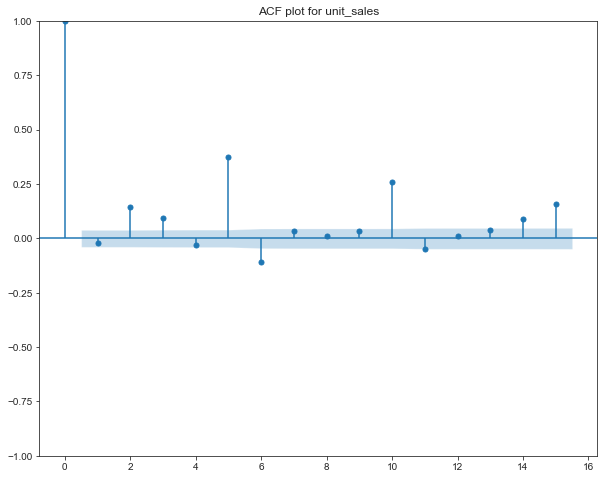

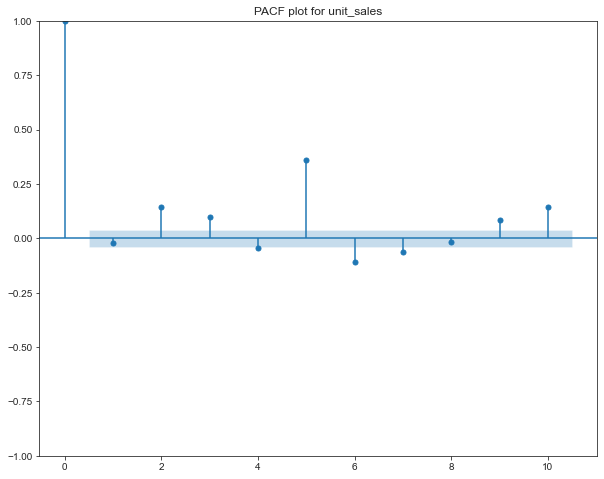

In [146]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

       
plot_acf(df['unit_sales'], lags=15)
plt.title('ACF plot for unit_sales')

plot_pacf(df['unit_sales'], lags=10, method='ols')
plt.title('PACF plot for unit_sales')

- **`There are several autocorrelations that are significantly non-zero. Therefore, the time series is non-random and is not white noise.`** <br>
- **`High degree of autocorrelation between adjacent (lag = 2) and near-adjacent (lag = 5) observations in PACF plot`**
- **`High degree of autocorrelation between several adjacent lag observations in ACF plot.`**

## Considering the autocorrelations based on ACF  & PACF plots - Create lagged features

In [147]:
def get_lagged_features(df, col):
    
    df_lagged = df.copy()
      
    df_lagged[f'{col}_lag_2'] = df_lagged[col].shift(2)
    df_lagged[f'{col}_lag_5'] = df_lagged[col].shift(5)    

    df_lagged = df_lagged.fillna(method='bfill')
    
    return df_lagged

df_lagged = get_lagged_features(df, 'unit_sales')
df_lagged.shape

(2534, 25)

## Create rolling window features

In [148]:
def get_rolling_window_features(df, col):
    
    df_rolling_window = df.copy()
      
    df_rolling_window[f'{col}_rolling_mean'] = df_rolling_window[col].rolling(window=8).mean()
    df_rolling_window = df_rolling_window.fillna(method='bfill')
    
    return df_rolling_window

df_rolling_window = get_rolling_window_features(df_lagged, 'unit_sales')
df_rolling_window.shape

(2534, 26)

In [149]:
df_rolling_window.head()

,dates,wholesaler_id_value,state_code,retailer_name,outlet_name,product_key,ab_category_style_value,ab_wamp_value,beer_style_value,brewer_value,type_value,unit_sales,dollar_sales,volume_sales,year,month,day,week,season,holiday,product_price,relative_beer_style_price,beer_style_mean_price,unit_sales_lag_2,unit_sales_lag_5,unit_sales_rolling_mean
0,2018-12-23,33107,NY,WEGMANS - WEGMANS,GROCERY,1412422,EASY DRINKING,PREMIUM,TROPICAL LAGER,CONSTELLATION BRANDS,BEER,22.00,318.78,11.00,2018,12,23,51,winter,0,14.49,0.97,14.96,22.00,22.00,30.50
1,2018-12-23,33107,NY,WEGMANS - WEGMANS,GROCERY,609521221,HARD BEVERAGES (BEER),BEYOND BEER,VARIETY PACK/SAMPLER,BOSTON BEER CO,MALT BEVERAGE,32.00,479.68,16.00,2018,12,23,51,winter,0,14.99,1.00,15.04,22.00,22.00,30.50
2,2018-12-23,33107,NY,WEGMANS - WEGMANS,GROCERY,1321133691,HARD BEVERAGES (BEER),BEYOND BEER,VARIETY PACK/SAMPLER,BOSTON BEER CO,MALT BEVERAGE,33.00,494.67,16.50,2018,12,23,51,winter,0,14.99,1.00,15.04,22.00,22.00,30.50
3,2018-12-23,33107,NY,WEGMANS - WEGMANS,GROCERY,659550424,HARD BEVERAGES (BEER),BEYOND BEER,VARIETY PACK/SAMPLER,MARK ANTHONY BRANDS INC,MALT BEVERAGE,30.00,448.70,15.00,2018,12,23,51,winter,0,14.96,0.99,15.04,32.00,22.00,30.50
4,2018-12-23,33107,NY,WEGMANS - WEGMANS,GROCERY,262793636,CRAFT & STYLES,PREMIUM,IPA,FOUNDERS BREWING CO,BEER,22.00,373.78,13.80,2018,12,23,51,winter,0,16.99,0.99,17.22,33.00,22.00,30.50


## Statistical test to check stationarity in time series 

**We will experiment with `Augmented Dickey-Fuller (ADF)`**

**Null Hypothesis (HO): Series is non-stationary.**

**Alternate Hypothesis(HA): Series is stationary.**

In [27]:
# Changing the YEAR data type and setting it as index
df_copy = df.copy()
df_copy.index = df_copy['dates']

del df_copy['dates']

# ADF Test
from statsmodels.tsa.stattools import adfuller

def adf_test(timeseries):
    print ('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print (dfoutput)
    

# Run test
adf_test(df_copy['unit_sales'])


Results of Dickey-Fuller Test:
Test Statistic                   -6.37
p-value                           0.00
#Lags Used                       22.00
Number of Observations Used   2,511.00
Critical Value (1%)              -3.43
Critical Value (5%)              -2.86
Critical Value (10%)             -2.57
dtype: float64


**The p-value is significant and hence, we can reject the null hypothesis and as expected, declare that the time series is infact stationary which is an assumption for the time series models.**

## Run statistical tests to understand impact of features on power consumption

**Run ANOVA, Kruskal-Wallis and post hoc tests for the categorical features to understand if the group means are statistically significant.**

In [150]:
anova_args = tuple(df.groupby('beer_style_value')['unit_sales'].apply(list).reset_index()['unit_sales'])
f_statistic, p_value = scipy.stats.f_oneway(*anova_args)

print(f_statistic, p_value)

150.09264351721407 2.5138263083016108e-62


In [151]:
# perform multiple pairwise comparison (Tukey HSD)
m_comp = pairwise_tukeyhsd(endog=df['unit_sales'], groups=df['beer_style_value'], alpha=0.05)
print(m_comp)

           Multiple Comparison of Means - Tukey HSD, FWER=0.05            
    group1            group2        meandiff p-adj   lower   upper  reject
--------------------------------------------------------------------------
           IPA       TROPICAL LAGER  19.5579  0.001 15.7201 23.3957   True
           IPA VARIETY PACK/SAMPLER  23.1916  0.001 20.0366 26.3467   True
TROPICAL LAGER VARIETY PACK/SAMPLER   3.6338 0.0181  0.4992  6.7684   True
--------------------------------------------------------------------------


**Running the ANOVA test on the weekdays column to understand if the each of the weekday category mean power consumption is statistically different from each other. And with a small p-value, it does seem like that is the case.** 

**Running a pairwise post hoc test to understand the differences in pairs of the groups in weekdays - looks like except (Friday, Monday), (Thursday, Tuesday), (Thursday, Wednesday) & (Tuesday, Wednesday) - all the other pairs seem to have statistically significantly different group means.**

In [152]:
kruskal_args = tuple(df.groupby('holiday')['unit_sales'].apply(list).reset_index()['unit_sales'])
h_statistic, p_value = scipy.stats.kruskal(*kruskal_args)
print(p_value)

0.9583902740417449


In [153]:
# perform multiple pairwise comparison (Tukey HSD)
m_comp = pairwise_tukeyhsd(endog=df['unit_sales'], groups=df['holiday'], alpha=0.05)
print(m_comp)

Multiple Comparison of Means - Tukey HSD, FWER=0.05
group1 group2 meandiff p-adj  lower  upper  reject
--------------------------------------------------
     0      1   0.9553 0.4952 -1.791 3.7016  False
--------------------------------------------------


**Running the Kruskal-wallis test on the non_working column to understand if the two categories have their difference in mean power consumption statistically significant from each other. And with a small p-value, it does seem like that is the case.** 

## Save the final data

In [154]:
df_with_features = df_rolling_window.copy()
df_with_features.to_csv('data/beer_data_with_features.csv', index=False)